<h1 style="color: #6686D6; font-family: 'Helvetica Neue', sans-serif;"><small>L7S2N2</small> Deployment Time</h1>

<h3 style="color: #6686D6; font-family: 'Helvetica Neue', sans-serif;">1. Transfer Setup</h3>

Go to the run documentation site we have used so far:

* [Run documentation](https://bernerfachhochschule.sharepoint.com/:l:/s/ti-bscdataengineering/FHp4B79xst1HjZfgPQHlnt4BRGeVdXH10vrHsrmSkZ8j0Q?e=zia76E)

### 1.1. Exercise: Choose one run (not one of yours, one of another group) and replicate the model and model training.

To verify that you successfully replicated the run compare the accuracy measured for your replicated run and the documented accuracy of the run.

If there are any discrepancies then contact the team that created the run and try to identify together what is the source of the discrepancy.

In [3]:
import pandas as pd
import numpy as np

tweets_df = pd.read_csv("./Brexit-Non-Brexit-100K.csv", delimiter=";", encoding='utf-8')
# We have to do some minimal clean-up of the dataset and replace missing values with empty strings (an empty string is still a string)
# If we don't do this we will run into an exception when we use the CountVectoriser
tweets_df['tweet'] = tweets_df['tweet'].replace(np.nan, '', regex=True)

#
from sklearn.model_selection import train_test_split
# Split the dataset into training and testing sets
X_train, X_test, y_train, y_test = train_test_split(tweets_df['tweet'], tweets_df['label'], test_size=0.2, random_state=42)
        

from sklearn.linear_model import LogisticRegression
from sklearn.feature_extraction.text import CountVectorizer

from sklearn.pipeline import make_pipeline
# Create a text processing and classification pipeline
ml_pipeline = make_pipeline(CountVectorizer(min_df=0.002, max_df=0.2), LogisticRegression(C=1e5, max_iter=10000))

from sklearn.metrics import accuracy_score
ml_pipeline.fit(X_train, y_train)
print("Accuracy:", accuracy_score(y_test, ml_pipeline.predict(X_test) ))

Accuracy: 0.97395


### 1.2. Review and Discussion



#### Replicating Model Training

Replicating the training of a model based on a run documentation (or a scientific paper) is a tedious and error-prone process.
Failing to replicate one important training hyperparameter will lead to a discrepancy in the observed performance.

To make sure we preserve the knowledge of our training efforts we should:

* Document the runs properly as shown on the shared run-board.
* Preserve the code base and the training data used for training
    * Note: For production-grade set-ups this can mean to pre-serve the full pipeline you used for collecting and annotating the training data
    * Note: To preserve the code base we need to point to a git commit hash or provide explicit documentation (just having a repository is not enough)
        * See: https://github.com/facebookresearch/ConvNeXt/blob/main/TRAINING.md for an example where all parameters for model training are described
        * See: https://paperswithcode.com as a platform dedicated to making ML model replication possible

As discussed in class, documenting runs is an extremely important aspect of the model training and model distribution workflow.
`ML-OPS` platforms (we will cover those in the coming semesters in detail) offer functionality that support Data and ML Engineers in the model training process. 

#### Example Weights & Biases ML Platform

Below is a screenshot from the platform. The concept of `Baseline` and the documentation on the right side should look familiar to you now. 
You can see that the hyperparameters are provided in the Note section of the model description. Many of the current ML-OPS platforms provide similar limited support for documenting the models. This can be fine as long as you do not change the ML-OPS platform or the underlying software stack for training. If you have to replicate the model from scratch however the minimum documentation given in the example will not be enough. Since the effort to document is relatively small (can be done in a couple of minutes) it is good to get into the habit of properly documenting your runs from the start.

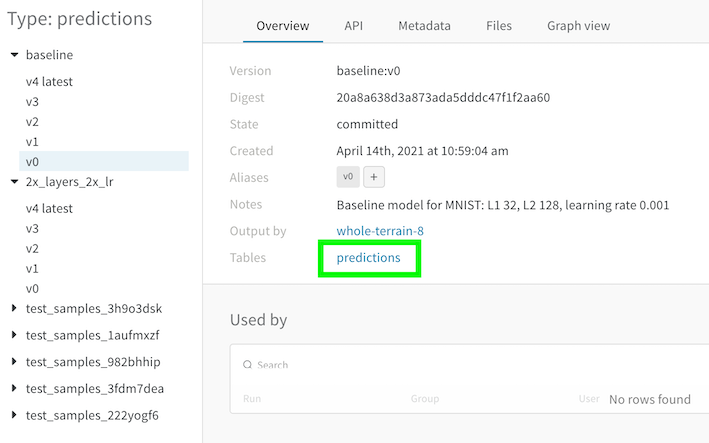


<h3 style="color: #6686D6; font-family: 'Helvetica Neue', sans-serif;">2. Model Serialization (Saving) with Joblib</h3> 

Replicating a model as we have done at the beginning of this notebook is usually reserved for instances where you want to build on the work of others and do not have the option to download an already trained model. 

Especially for larger models with extensive training time we want to be able to just store the current training state of our models.

### 2.1 The easy but brittle way to serialize

The easy way to store your model is to use `serialization` on the code level.
This is a common way to preserve code state across programming languages. 

The approach is as follows:
* The method stores the actual text of your code. That is, all the python code that forms part of your program together with all the method parameters and all the variable values in your current program state.
* The end-product of this operation is a compressed file that contains all of the above information.
* When you want to then load the model again it will load the variable values that make up your model state, and also the code that was used to create your model.

#### Example Serialization with Joblib


#### Serialize:

First, ensure you have `joblib` installed:

```bash
!pip install joblib
```

Then, you can create and save the model:

```python
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
import joblib

# Sample data
X = ["sample text data", "more text data"] # Replace with your text data
y = [0, 1] # Replace with your labels

# Creating a pipeline with CountVectorizer and LogisticRegression
pipeline = Pipeline([
('vect', CountVectorizer()),
('clf', LogisticRegression())
])

# Fit the pipeline on your data
pipeline.fit(X, y)

# Save the model
joblib.dump(pipeline, 'text_classification_model.joblib')
```

#### Loading the Model:

To load the model back for later use:

```python
# Load the model
loaded_model = joblib.load('text_classification_model.joblib')
loaded_model.predict(["more text data"])
# Use the loaded model to make predictions
# new_data = ["new unseen text data"]
# predictions = loaded_model.predict(new_data)
```

### 2.2 Exercise: 

Use the above code example to serialize the model from the top of the notebook.

* First serialize the model in a file of your choice
* Then load the model again and verify that you achieve the same accuracy

Note: You do not have to copy or re-write the code for creating the pipeline. You just have to use the `pipeline` object from the replicated model at the top of the notebook.

In [6]:
import joblib

joblib.dump(ml_pipeline, 'text_classification_model.joblib')

['text_classification_model.joblib']

In [8]:
loaded_model = joblib.load('text_classification_model.joblib')
print("Accuracy:", accuracy_score(y_test, ml_pipeline.predict(X_test) ))

Accuracy: 0.97395


#### 2.3 The Disadvantage

Using joblib (or pickle another alternative) is a very easy way to save the model state.
It comes however with a rather big disadvantage. 

This is hinted at in the joblib documentation:

https://joblib.readthedocs.io/en/latest/persistence.html#compatibility-across-python-versions 

What is described there can be summarized in a nutshell like this:

Because the method just writes down all the variable values and on top of that the "text" of your code, it will run into problems once something changes in the software versions used to run the code. 

Note: If you switch the version of sci-kit learn or the python version then there is a growing danger that you will not be able to load your models again. 

<h3 style="color: #6686D6; font-family: 'Helvetica Neue', sans-serif;">3. Robust Model Saving</h3> 

We saw the disadvantages of storing models the brute force way.

What is the alternative? By now you might ask yourself what is stored in the model when we train it.
In essence the machine learning models consist of double values that represent the weights (also called parameters) of the model.

Here is an example of the weights of a logistic regression model.

```
[-1.07091645 -0.07848958  0.66913624  0.43500273]
```

We will dive into this in the next semester. For now we will use this to come up with a way to store our model state.
Instead of storing the code surrounding the model we can store the weight values.

### 3.1 Storing a Scikit-Learn Model with CountVectorizer in ONNX Format

ONNX (Open Neural Network Exchange) offers an interoperable format that can be used across different programming languages, frameworks, and tools.

#### Installation

First, install the required packages:

```bash
!pip install onnx onnxruntime skl2onnx
```

#### Saving the Model as ONNX

```python
from sklearn.feature_extraction.text import CountVectorizer
from sklearn.linear_model import LogisticRegression
from sklearn.pipeline import Pipeline
from skl2onnx import convert_sklearn
from skl2onnx.common.data_types import StringTensorType
import onnx

# Sample data
X = ["sample text data", "more text data"] # Replace with your text data
y = [0, 1] # Replace with your labels

# Creating a pipeline with CountVectorizer and LogisticRegression
pipeline = Pipeline([
('vect', CountVectorizer()),
('clf', LogisticRegression())
])

# Fit the pipeline on your data
pipeline.fit(X, y)

# Convert the model to ONNX format
initial_type = [('string_input', StringTensorType([None, 1]))]
onnx_model = convert_sklearn(pipeline, initial_types=initial_type)

# Save the ONNX model to a file
with open("text_classification_model.onnx", "wb") as f:
    f.write(onnx_model.SerializeToString())
```

#### Loading and Using the ONNX Model

To load and use the ONNX model:

```python
import onnxruntime as ort
import numpy as np

# Load the ONNX model
sess = ort.InferenceSession("text_classification_model.onnx")

# Prepare sample data for prediction
new_data = np.array(["new unseen text data"]).reshape(1, 1)

# Run the model (inference)
input_name = sess.get_inputs()[0].name
output_name = sess.get_outputs()[0].name
predictions = sess.run([output_name], {input_name: new_data})[0]

print(predictions)
```

Using ONNX for model storage ensures interoperability, making it useful for deploying models in various environments or using them with frameworks supporting ONNX.

#### ONNX Compatibility

ONNX is a widely supported format for storing the model state.
Visit the link below to get some insight into the supported tools and platforms.

https://onnx.ai/supported-tools


### 3.2 Exercise: Store your model in ONNX format.

* First serialize the model in a file of your choice
* Then load the model again and verify that you achieve the same accuracy

Note: You do not have to copy or re-write the code for creating the pipeline. You just have to use the `pipeline` object from the replicated model at the top of the notebook.